In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score, precision_recall_curve


# **General Analysis**

In [ ]:
data_path = r"\data\raw\storedata_total.xlsx"
df_raw = pd.read_excel(data_path,sheet_name='data',header=0, engine='openpyxl')
df_raw.head(5)

c:\Users\jhoni\Documents\LooperAI\repositorios\bb-tech-challenge\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM


In [4]:
df_raw.shape

(30801, 15)

In [7]:
df_raw.dtypes

custid                object
retained               int64
created       datetime64[ns]
firstorder            object
lastorder             object
esent                  int64
eopenrate            float64
eclickrate           float64
avgorder             float64
ordfreq              float64
paperless              int64
refill                 int64
doorstep               int64
favday                object
city                  object
dtype: object

In [8]:
# Check missing values
missing = df_raw.isnull().sum()
missing_pct = (missing/len(df_raw)*100).round(2)
missing_df = pd.DataFrame(
    {
        "count": missing,
        "pct": missing_pct
    }
)
missing_df.sort_values('pct', ascending=False)

,count,pct
custid,20,0.06
created,20,0.06
firstorder,20,0.06
lastorder,20,0.06
retained,0,0.00
esent,0,0.00
eopenrate,0,0.00
eclickrate,0,0.00
avgorder,0,0.00
ordfreq,0,0.00


In [9]:
# Check correlated nulls in top 4
df_null = df_raw[["custid", "created", "firstorder", "lastorder"]].isnull()

# Identify if all elements al nulls
all_null = df_null.all(axis=1).sum()

# Identify in at least one is null
any_null = df_null.any(axis=1).sum()

print(f"{all_null}, {any_null}")

20, 20


In [24]:
# Check duplicates
duplicates_count = df_raw.duplicated().sum()

# Check duplicates in id
id_duplicates = df_raw['custid'].dropna().duplicated().sum()

print(f"Total duplicates: {duplicates_count}, ID duplicates: {id_duplicates}")

Total duplicates: 0, ID duplicates: 12


# **Target Analysis**

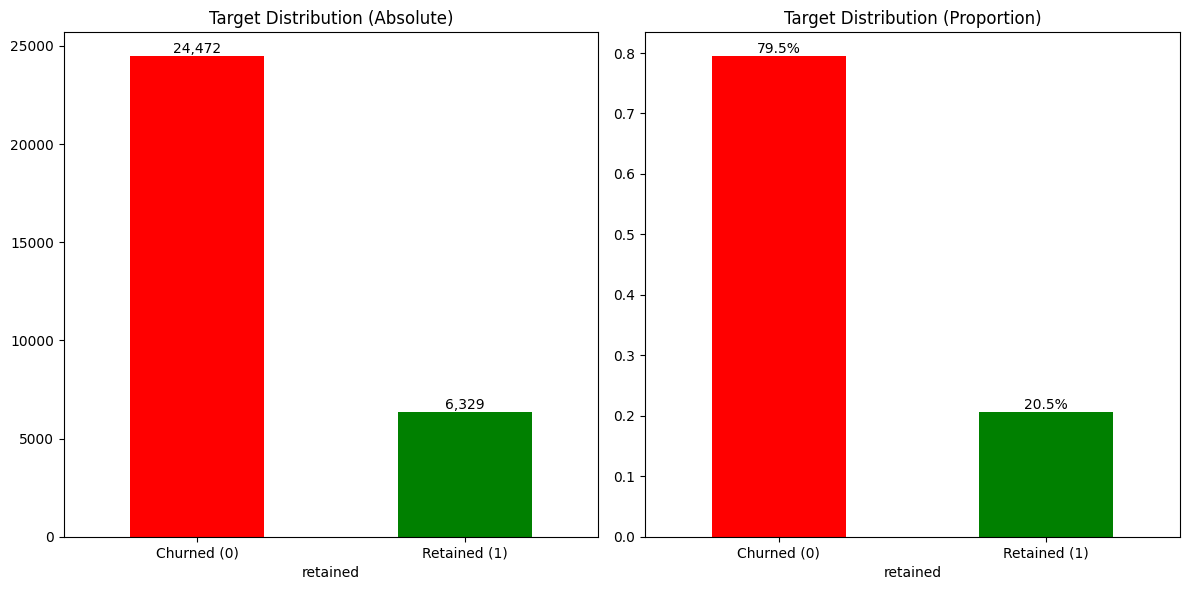

In [25]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Graph absolute values
df_raw['retained'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=['red','green']
)
axes[0].set_title("Target Distribution (Absolute)")
axes[0].set_xticklabels(["Churned (0)", "Retained (1)"], rotation=0)

# Add bar labels
for p in axes[0].patches:
    axes[0].annotate(
        f'{int(p.get_height()):,}', 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='bottom'
    )
    
    
# Proportions
df_raw['retained'].value_counts(normalize=True).plot(
    kind='bar',
    ax=axes[1],
    color=["red", "green"]
)
axes[1].set_title("Target Distribution (Proportion)")
axes[1].set_xticklabels(["Churned (0)", "Retained (1)"], rotation=0)

for p in axes[1].patches:
    axes[1].annotate(
        f'{p.get_height():.1%}', 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='bottom'
    )
    

plt.tight_layout()
plt.show()

In [12]:
df_raw['retained'].value_counts()
print(f"Imbalance ratio: {df_raw['retained'].value_counts()[1] / df_raw['retained'].value_counts()[0]:.1f}:1")

Imbalance ratio: 3.9:1


In [13]:
print(f"Imbalance ratio: {df_raw['retained'].value_counts()[1] / df_raw['retained'].value_counts()[0]:.1f}:1")

Imbalance ratio: 3.9:1


## Conclusions
The dataset exhibits moderate class imbalance at approximately 79.5% retained vs 20.5% churned (roughly 4:1 ratio). The strategy i'll choose:

1. Metric selection: ROC-AUC will be misleadingly optimistic because the large number of true negatives inflates the FPR denominator. PR-AUC is my primary metric.
2. Training strategy: I'll use class_weight='balanced' for Logistic Regression and scale_pos_weight ≈ 3.87 for XGBoost to prevent the models from optimizing for the majority class.
3. Threshold selection: The default 0.5 threshold will produce high precision but low recall on the churn class. I'll optimize the threshold on the validation set.
4. This is NOT extreme imbalance. At 20.5%, standard techniques like class weights and threshold tuning are sufficient. SMOTE or other resampling methods is not required here.

# **Feature Analysis**
## Numeric Feature Analysis

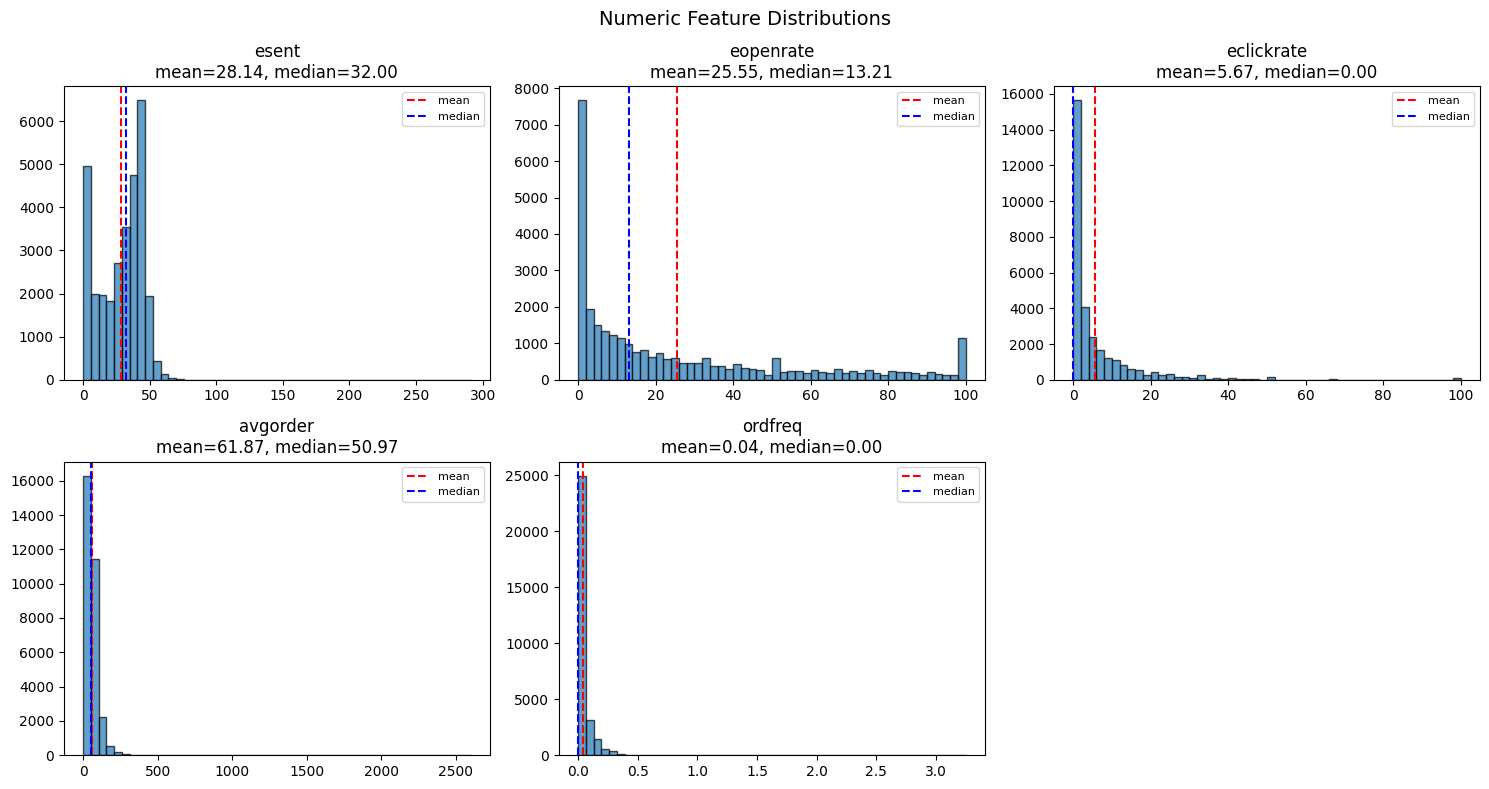

In [23]:
numeric_cols = ["esent", "eopenrate", "eclickrate", "avgorder", "ordfreq"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df_raw[col].dropna(), bins=50, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"{col}\nmean={df_raw[col].mean():.2f}, median={df_raw[col].median():.2f}")
    axes[i].axvline(df_raw[col].mean(), color="red", linestyle="--", label="mean")
    axes[i].axvline(df_raw[col].median(), color="blue", linestyle="--", label="median")
    axes[i].legend(fontsize=8)

axes[-1].axis("off")
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()


The gap between mean and median reveals skewness. 
- For `eclickrate` and `eopenrate`, if the median is much higher than mean, it is a right-skew from outliers. This matters because Logistic Regression assumes a roughly linear relationship.
- Trees are robust here, which is one reason XGBoost is ofter better than linear models on raw tabular data.

In [52]:
'float' == df_raw['avgorder'].dtype

True

In [1]:
zero_pct = (df_raw['avgorder'] == 0.0).mean() * 100
print(f"avgorder: {zero_pct:.1f}% zeros")

NameError: name 'df_raw' is not defined

In [59]:
for col in numeric_cols:
    zero_pct = (df_raw[col] == 0).mean() * 100  
    if zero_pct > 5:
        print(f"{col}: {zero_pct:.2f}% zeros")

esent: 11.05% zeros
eopenrate: 24.76% zeros
eclickrate: 50.24% zeros
ordfreq: 61.75% zeros


This suggests a bimodal population: users who engage vs. users who don't. A single numeric feature can't capture both 'did they engage at all?' and 'if yes, how much?'. 

For a production version, I'd consider splitting these into a binary flag and a conditional continuous feature. For this challenge, the tree models are enough through splits.

### TargetClass-Conditional Distributions
This will show me if numeric features actually separate the target classes

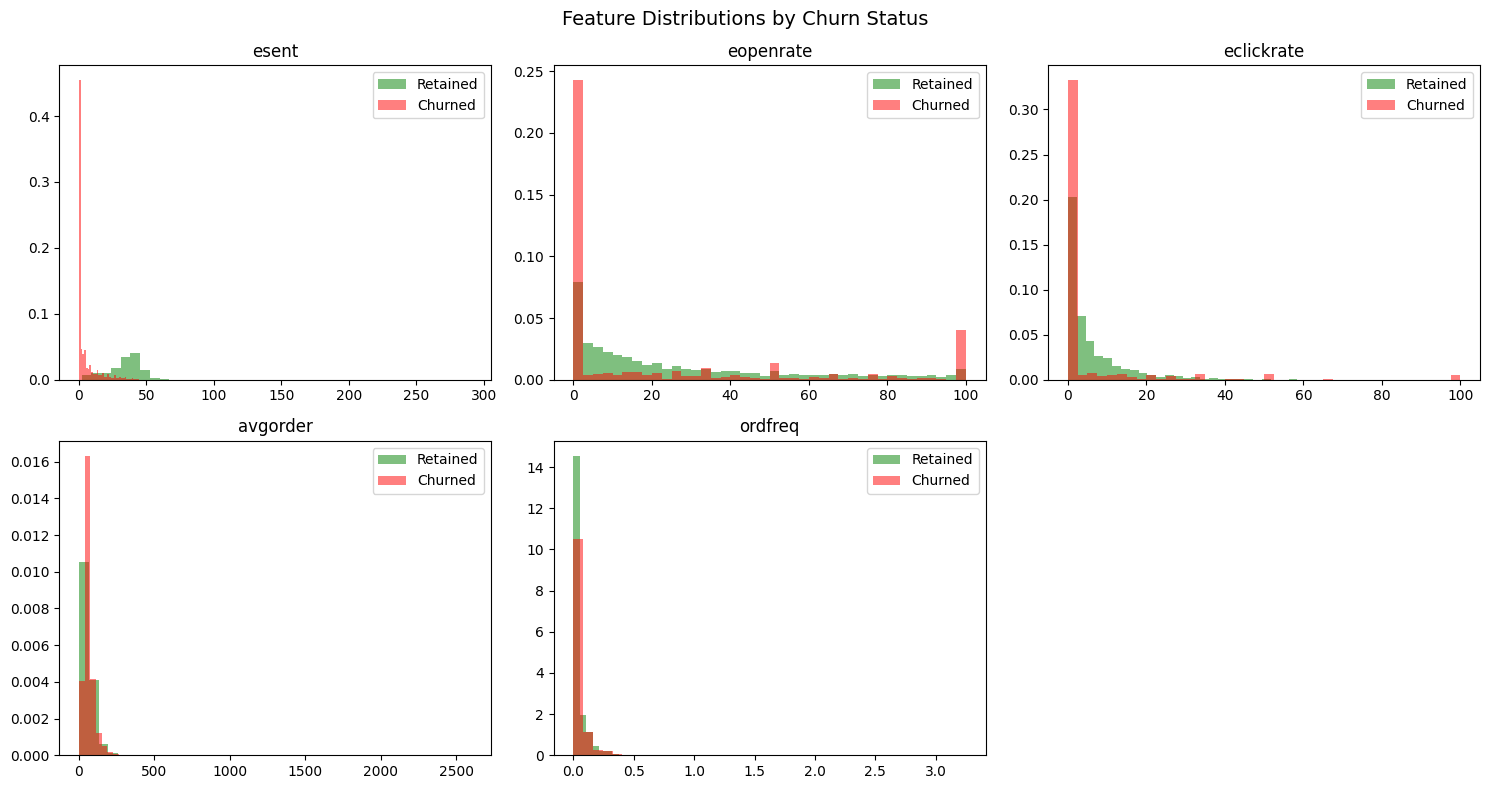

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    churned = df_raw[df_raw["retained"] == 0][col].dropna()
    retained = df_raw[df_raw["retained"] == 1][col].dropna()
    
    axes[i].hist(retained, bins=40, alpha=0.5, label="Retained", density=True, color="green")
    axes[i].hist(churned, bins=40, alpha=0.5, label="Churned", density=True, color="red")
    axes[i].set_title(col)
    axes[i].legend()

axes[-1].axis("off")
plt.suptitle("Feature Distributions by Churn Status", fontsize=14)
plt.tight_layout()
plt.show()

Features where the two histograms barely overlap are strong predictors. Features where they overlap almost completely are noise. They carry little discriminative information. 

This visual help me to indentify which features the model will rely on and which it will ignore.

In [ ]:
for col in numeric_cols:
    churned_mean = df_raw[df_raw["retained"] == 0][col].mean()
    retained_mean = df_raw[df_raw["retained"] == 1][col].mean()
    
    pooled_std = df_raw[col].std()
    cohens_d = abs(churned_mean - retained_mean) / pooled_std
    
    print(f"{col}: Cohen's d = {cohens_d:.3f} ({'strong' if cohens_d > 0.8 else 'moderate' if cohens_d > 0.5 else 'weak'})")

esent: Cohen's d = 1.776 (strong)
eopenrate: Cohen's d = 0.185 (weak)
eclickrate: Cohen's d = 0.106 (weak)
avgorder: Cohen's d = 0.010 (weak)
ordfreq: Cohen's d = 0.027 (weak)


Cohen's d measures effect size: how the class means are far apart in standard deviation units

- A d > 0.8 is a strong effect
- 0.5-0.8 is moderate
- < 0.5 is weak. 

This give me a ranking of feature importance before training any model. If the model's feature importance later disagrees with these effect sizes, it tells me the model is capturing interactions, not just marginal effects.

## Categorical Features Analysis

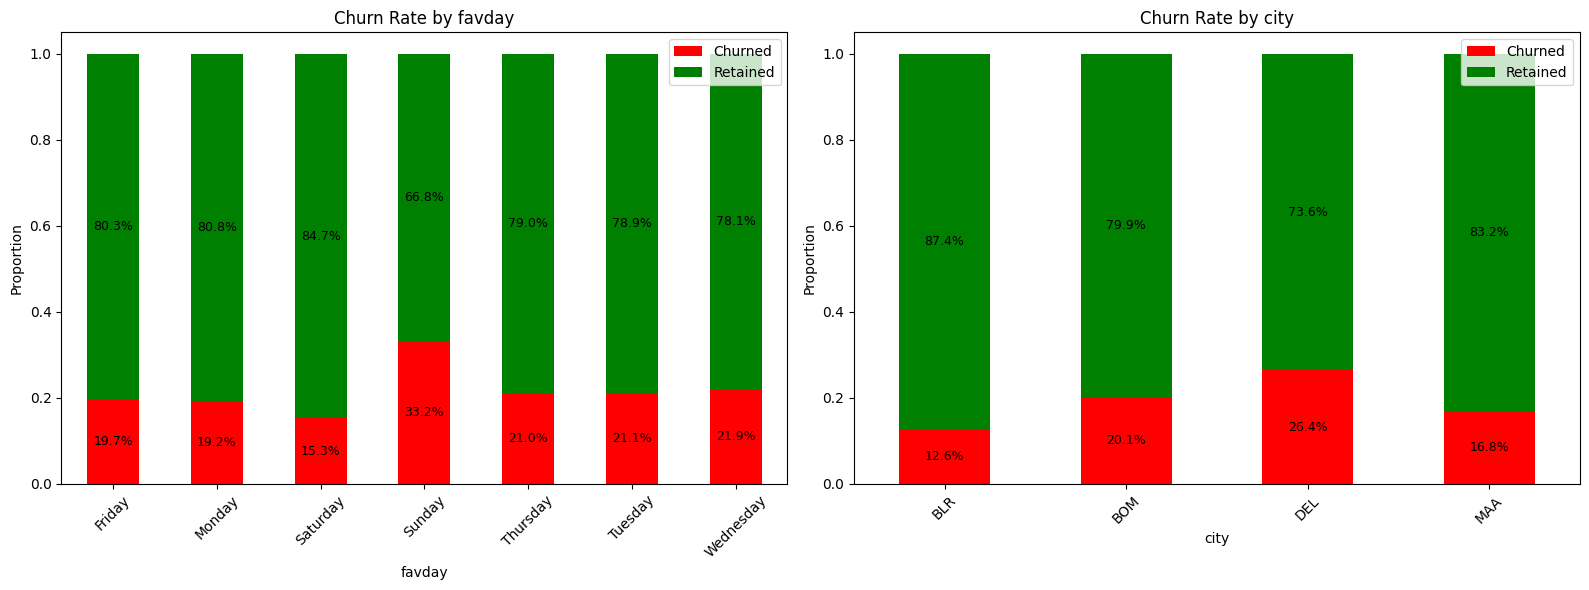

In [ ]:
cat_cols = ["favday", "city"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df_raw[col], df_raw["retained"], normalize="index")
    ct.plot(kind="bar", stacked=True, ax=axes[i], color=["red", "green"])
    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].set_ylabel("Proportion")
    axes[i].legend(["Churned", "Retained"])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%', 
                        label_type='center', fontsize=9, 
                        labels=[f'{v.get_height()*100:.1f}%' for v in container])
plt.tight_layout()
plt.show()

In [84]:

for col in cat_cols:
    ct = pd.crosstab(df_raw[col], df_raw["retained"])
    stat, p, dof, expected = chi2_contingency(ct)
    print(f"{col}: chi2 = {stat:.2f}, p = {p:.4f}, significant={p < 0.05}") # type: ignore

favday: chi2 = 100.47, p = 0.0000, significant=True
city: chi2 = 324.73, p = 0.0000, significant=True


Insgihts:
- churn rate is roughly constant across all categories of favday. This feature could be dropped.
- city shows meaningful variation, it's a useful feature.
- Even if chi-square shows statistical significance, the effect might be too small to matter. With 30k observations, chi-square can detect tiny differences. Check the actual churn rate variation across categories: if it's within 2-3 percentage points, the feature adds minimal information despite being 'statistically significant'

## Binary Features Analysis

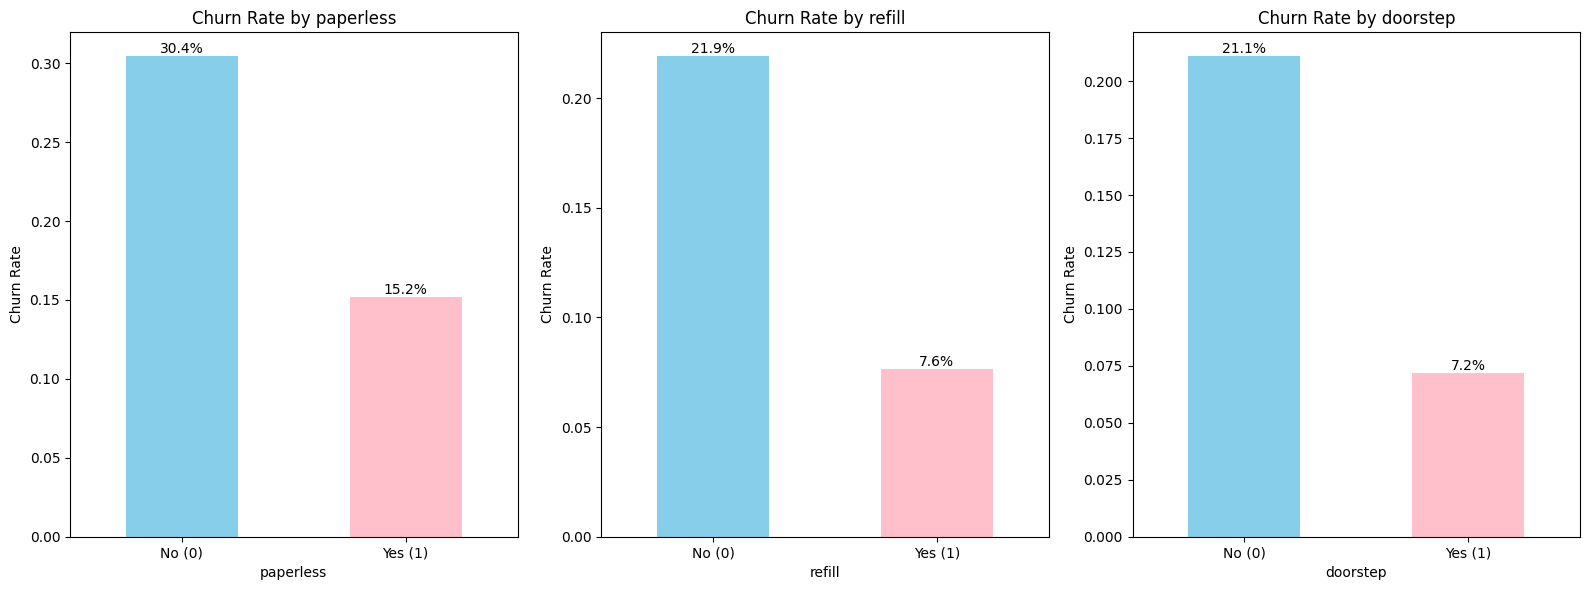

In [ ]:
binary_cols = ["paperless", "refill", "doorstep"]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, col in enumerate(binary_cols):
    churn_rates = df_raw.groupby(col)["retained"].apply(lambda x: (x == 0).mean())
    churn_rates.plot(kind="bar", ax=axes[i], color=["skyblue", "pink"])
    
    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].set_ylabel("Churn Rate")
    axes[i].set_xticklabels(["No (0)", "Yes (1)"], rotation=0)

    for p in axes[i].patches:
        axes[i].annotate(
            f'{p.get_height():.1%}',
            (p.get_x() + p.get_width()/2., p.get_height()),
            ha='center', va='bottom'
        )

plt.tight_layout()
plt.show()

Binary features in churn models often represent product adoption. 

For instance, If paperless=1 users churn less, it's likely because opting into paperless is a sign of engagement, not because paperless billing itself prevents churn. This distinction matters for causal interpretation even though the model doesn't need to know the causal direction.

# **Leakage Analysis**
Analysing date columns

In [99]:
df_clean = df_raw.dropna(subset=["custid"]).copy()

for col in ["created", "firstorder", "lastorder"]:
    df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")

for col in ["created", "firstorder", "lastorder"]:
    print(f"  {col} column range: {df_clean[col].min().date()} to {df_clean[col].max().date()}")

  created column range: 2008-06-17 to 2018-01-17
  firstorder column range: 2008-07-29 to 2018-01-21
  lastorder column range: 2008-07-29 to 2018-01-21


## Temporal Engineered Features

In [101]:
ref_date = df_clean["created"].max()

# create tenure_days eng feature
df_clean["tenure_days"] = (ref_date - df_clean["created"]).dt.days
tenure_safe = df_clean["tenure_days"].replace(0, 1)

# create days_first_to_last_order eng feature
df_clean["days_first_to_last_order"] = (
    df_clean["lastorder"] - df_clean["firstorder"]
).dt.days.fillna(0).clip(lower=0) # type: ignore

# create days_since_first_order eng feature
df_clean["days_since_first_order"] = (
    ref_date - df_clean["firstorder"]
).dt.days.fillna(0).clip(lower=0)

# create 
days_since_last = (ref_date - df_clean["lastorder"]).dt.days.fillna(tenure_safe)
df_clean["order_recency_ratio"] = 1 - (days_since_last / tenure_safe).clip(0, 1)

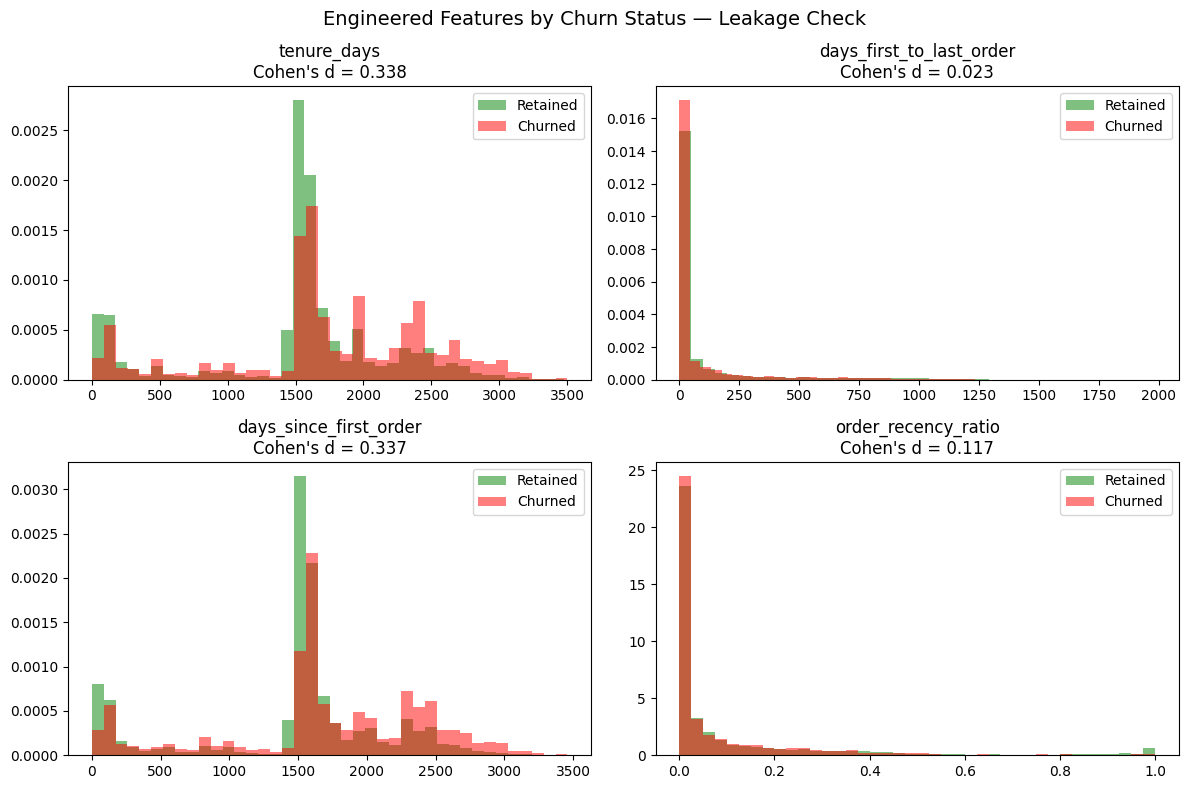

In [103]:
engineered = ["tenure_days", "days_first_to_last_order", 
              "days_since_first_order", "order_recency_ratio"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(engineered):
    churned = df_clean[df_clean["retained"] == 0][col]
    retained = df_clean[df_clean["retained"] == 1][col]
    
    axes[i].hist(retained, bins=40, alpha=0.5, label="Retained", density=True, color="green")
    axes[i].hist(churned, bins=40, alpha=0.5, label="Churned", density=True, color="red")
    
    # Cohen's d
    d = abs(churned.mean() - retained.mean()) / df_clean[col].std()
    axes[i].set_title(f"{col}\nCohen's d = {d:.3f}")
    axes[i].legend()

plt.suptitle("Engineered Features by Churn Status — Leakage Check", fontsize=14)
plt.tight_layout()
plt.show()

In [119]:
print("Single-feature ROC AUC (how predictive is each feature alone?):")
for col in engineered + numeric_cols:
    try:
        vals = df_clean[col].fillna(0).values
        target = (df_clean["retained"] == 0).astype(int).values
        auc = roc_auc_score(target, vals) # type: ignore
        auc = max(auc, 1 - auc)
        flag = " XX SUSPICIOUSLY HIGH" if auc > 0.85 else ""
        print(f"  {col}: ROC AUC = {auc:.4f}{flag}")
    except:
        pass

Single-feature ROC AUC (how predictive is each feature alone?):
  tenure_days: ROC AUC = 0.6250
  days_first_to_last_order: ROC AUC = 0.5119
  days_since_first_order: ROC AUC = 0.6305
  order_recency_ratio: ROC AUC = 0.5187
  esent: ROC AUC = 0.9668 XX SUSPICIOUSLY HIGH
  eopenrate: ROC AUC = 0.6588
  eclickrate: ROC AUC = 0.6790
  avgorder: ROC AUC = 0.5035
  ordfreq: ROC AUC = 0.5151


## Correlation Matrix

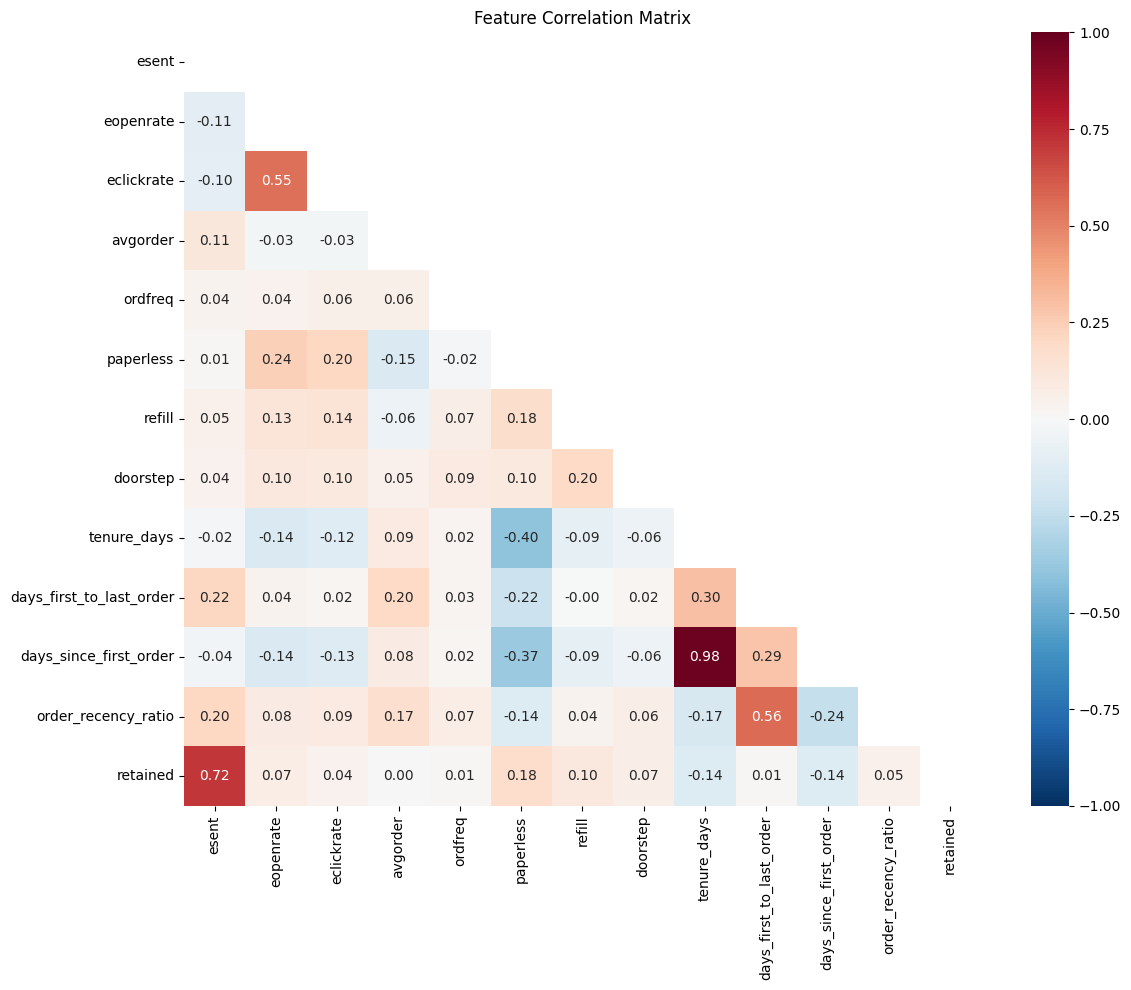

In [109]:
all_features = numeric_cols + binary_cols + engineered
corr = df_clean[all_features + ["retained"]].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", 
            center=0, vmin=-1, vmax=1, ax=ax)
ax.set_title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [112]:
target_corr = corr["retained"].drop("retained").sort_values()
print("Correlations with target (retained):")
print(target_corr.to_string())

Correlations with target (retained):
tenure_days                -0.136408
days_since_first_order     -0.136326
avgorder                    0.004276
days_first_to_last_order    0.009224
ordfreq                     0.010739
eclickrate                  0.042661
order_recency_ratio         0.047273
doorstep                    0.066563
eopenrate                   0.074943
refill                      0.103652
paperless                   0.180333
esent                       0.717573


Multicollinearity between features: If tenure_days and days_since_first_order have correlation > 0.9, they carry nearly identical information. For Logistic Regression, this inflates coefficient variance (makes interpretation unreliable) but doesn't hurt prediction. For XGBoost, it's harmless — the model simply picks whichever feature gives better splits. You should note the correlation but don't necessarily need to drop features.
Correlation with target: This gives you a linear preview of feature importance. But remember — this only captures linear relationships. ordfreq might have low correlation with retained overall but be highly predictive for specific subgroups. Trees will capture this; the correlation matrix won't show it.

## Summary Stats by Target Class

In [117]:
summary = df_clean.groupby("retained")[all_features].agg(["mean", "median", "std"])
summary

esent                    eopenrate                        \
               mean median        std       mean     median        std   
retained                                                                 
0          4.498181    0.0   8.274368  21.199560   0.000000  33.950591   
1         34.247853   36.0  12.392901  26.682101  15.789474  28.200694   

         eclickrate                        avgorder  ... tenure_days  \
               mean    median        std       mean  ...         std   
retained                                             ...               
0          4.786347  0.000000  15.224623  61.496173  ...  753.646031   
1          5.901825  2.564103   8.959788  61.929439  ...  705.700815   

         days_first_to_last_order                    days_since_first_order  \
                             mean median         std                   mean   
retained                                                                      
0                       86.435553    0.0  213.550229            1704.633718   
1                       91.528702    0.0  225.471163            1466.347126   

                             order_recency_ratio                      
          median         std                mean    median       std  
retained                                                              
0         1644.0  740.986924            0.081959  0.008883  0.161300  
1         1555.0  688.495968            0.105347  0.012874  0.208433  

[2 rows x 36 columns]